In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [14]:
learning_set = pd.read_csv('ML_DataFrame.csv')
print(learning_set.head())
print(learning_set.isna().sum())

Unnamed: 0  label  urls_count  protocol  contains_ip  url_length  \
0           0    1.0         1.0       0.0          0.0        21.0   
1           1    1.0         1.0       0.0          0.0        25.0   
2           2    1.0         3.0       0.0          0.0        68.0   
3           3    0.0         3.0       0.0          0.0        14.0   
4           4    1.0         1.0       0.0          0.0       136.0   

   TLD_alpha  subdomain_level  slash_count  dots_count  hyphens_count  \
0        1.0              0.0          3.0         1.0            0.0   
1        1.0              1.0          2.0         2.0            0.0   
2        1.0              1.0          6.0         4.0            0.0   
3        1.0              1.0          0.0         2.0            0.0   
4        1.0              2.0          4.0         4.0            2.0   

   has_non_latin  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
Unnamed: 0           0


In [15]:
# TODO: naprawić NaN w subdomain level
learning_set.dropna(inplace=True)

In [16]:
X = learning_set.loc[:, 'urls_count':'has_non_latin'].values
y = learning_set.loc[: , 'label'].values
print(X.shape, y.shape)

(41126, 10) (41126,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [18]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(32900, 10) (8226, 10) (32900,) (8226,)


In [19]:
n_range = range(2, 30)
scores = []
for n in n_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    # kf = KFold(n_splits=6, shuffle=True, random_state=42)
    # cv_score = cross_val_score(knn, X_train, y_train, cv=kf)
    # print(cv_score)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    scores.append(score)


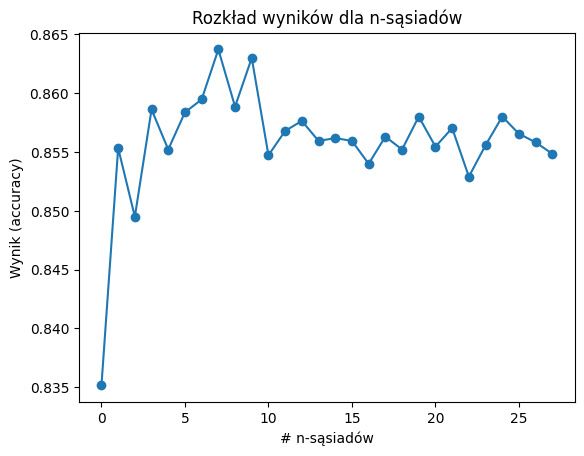

In [20]:
fig, ax = plt.subplots()
values = scores
labels = n_range
ax.plot(values, marker='o')
ax.set_xlabel('# n-sąsiadów')
#ax.set_xticks(n_range) #naprawic oś X
ax.set_ylabel('Wynik (accuracy)')
ax.set_title('Rozkład wyników dla n-sąsiadów')

plt.show()

In [21]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=8),
}

results = []
for model in models.values():
    kf = KFold(n_splits=6, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=kf)
    results.append(score)


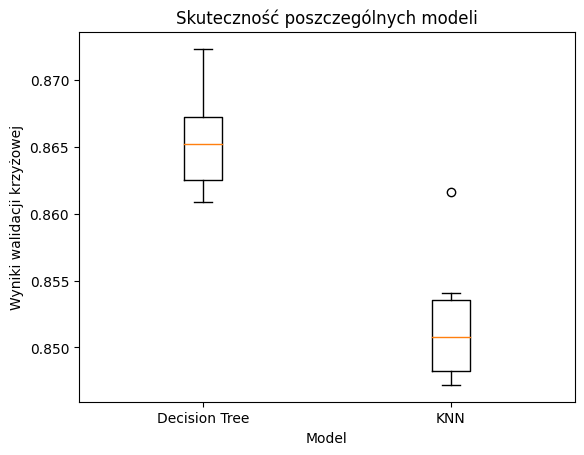

In [22]:
fig, ax = plt.subplots()

ax.boxplot(results, labels=models.keys())
ax.set_title('Skuteczność poszczególnych modeli')
ax.set_xlabel('Model')
ax.set_ylabel('Wyniki walidacji krzyżowej')
plt.show()

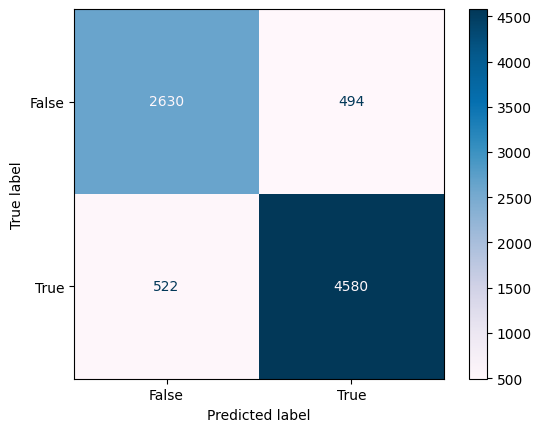

In [25]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot(cmap='PuBu')
plt.show()